# Multimodal Neural Network

```
     __
    (__)_
    (____)_
    (______)
...//(  00 )\......version 1.0
```

In [12]:
%load_ext autoreload
%autoreload 2
# Python Standard Libraries
from datetime import datetime
import glob
import itertools
import math
import os
import random
import re
import time
import warnings
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision

# Other libraries
# ~ Scientific
import numpy as np
import scipy.stats as st
# ~ Image manipulation / visualisation
import imgaug
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skimage
import skimage.io as skio
import skimage.transform as sktr
# ~ Other
from tqdm.notebook import tqdm

# Local libraries
from utils.image import *
from utils.torch import *

# IPython
from IPython.display import clear_output, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
count = torch.cuda.device_count()
print(f"{count} GPU device(s) available.")
print()
print("List of GPUs:")
for i in range(count):
    print(f"* {torch.cuda.get_device_name(i)}")

1 GPU device(s) available.

List of GPUs:
* TITAN Xp


In [4]:
# METHOD RELATED
# The place where the models will be saved
export_folder = "results" # Add this path to the .gitignore
# The number of channels in the latent space (best is 1 or 3 for visualization)
latent_channels = 3
# Modality slicing
# You can choose a set of channels per modality (RGB for instance)
# Modality A
modA = slice(0, 1)
modA_name = "SHG"
modA_len = modA.stop - modA.start
# Modality B
modB = slice(1, 4)
modB_name = "BF"
modB_len = modB.stop - modB.start
# Distance function
simfunctions = {
    "euclidean" : lambda x, y: -torch.norm(x - y, p=2, dim=1).mean(),
    "L1"        : lambda x, y: -torch.norm(x - y, p=1, dim=1).mean(),
    "MSE"       : lambda x, y: -(x - y).pow(2).mean(),
    "L3"        : lambda x, y: -torch.norm(x - y, p=3, dim=1).mean(),
    "Linf"      : lambda x, y: -torch.norm(x - y, p=float("inf"), dim=1).mean(),
    "soft_corr" : lambda x, y: F.softplus(x*y).sum(axis=1),
    "corr"      : lambda x, y: (x*y).sum(axis=1),
    "cosine"    : lambda x, y: F.cosine_similarity(x, y, dim=1, eps=1e-8).mean(),
    "angular"   : lambda x, y: F.cosine_similarity(x, y, dim=1, eps=1e-8).acos().mean() / math.pi,
}
sim_func = simfunctions["MSE"]
# Temperature (tau) of the loss
tau =  0.1
# L1/L2 activation regularization
act_l1 = 0
act_l2 = 0
# p4 Equivariance (should always be True, unless you want to see how everything breaks visually otherwise)
equivariance = True

# DEEP LEARNING RELATED
# Device to train on (inference is done on cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
# Use two GPUs?
device1 = device2 = device # 1 gpu for 2 modalities
#device1, device2 = "cuda:0", "cuda:1" # 1 gpu per modality
# Arguments for the tiramisu neural network
tiramisu_args = {
    # Number of convolutional filters for the first convolution
    "init_conv_filters": 32,
    # Number and depth of down blocks
    "down_blocks": (4, 4, 4, 4, 4, 4),
    # Number and depth of up blocks
    "up_blocks": (4, 4, 4, 4, 4, 4),
    # Number of dense layers in the bottleneck
    "bottleneck_layers": 4,
    # Upsampling type of layer (upsample has no grid artefacts)
    "upsampling_type": "upsample",
    # Type of max pooling, blurpool has better shift-invariance
    "transition_pooling": "max",
    # Dropout rate for the convolution
    "dropout_rate": 0.2,
    # Early maxpooling to reduce the input size
    "early_transition": False,
    # Activation function at the last layer
    "activation_func": None,
    # How much the conv layers should be compressed? (Memory saving)
    "compression": 0.75,
    # Memory efficient version of the tiramisu network (trades memory for computes)
    # Gains of memory are enormous compared to the speed decrease.
    # See: https://arxiv.org/pdf/1707.06990.pdf
    "efficient": False,
}
# Epochs
epochs = 30
# Batch size
batch_size = 24
# Steps per epoch
steps_per_epoch = 32
# Number of steps
steps = steps_per_epoch * epochs
# How many unique patches are fed duriing one epoch
samples_per_epoch = steps_per_epoch * batch_size
# Optimiser
#from lars.lars import LARS
#optimiser = LARS
optimiser = optim.SGD
# Optimizer arguments
opt_args = {
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "momentum": 0.9
}
# Gradient norm. (limit on how big the gradients can get)
grad_norm = 1.0

# DATASET RELATED
def worker_init_fn(worker_id):
    base_seed = int(torch.randint(2**32, (1,)).item())
    lib_seed = (base_seed + worker_id) % (2**32)
    imgaug.seed(lib_seed)
    np.random.seed(lib_seed)

dataloader_args = {
    "batch_size": batch_size,
    "shuffle": False,
    "num_workers": 16,
    "pin_memory": True,
    "worker_init_fn": worker_init_fn,
}

In [5]:
class SlideDataset(Dataset):
    def __init__(self, folder_path, name_regex=r"(?P<name>.*_(?P<type>.*)\.", logMI=True, transform=None):
        self.transform = transform
        if not isinstance(folder_path, list):
            folder_path = [folder_path]
        self.path = folder_path
        self.filenames = [glob.glob(path) for path in folder_path]
        self.filenames = list(itertools.chain(*self.filenames))

        dataset = {}
        pbar = tqdm(total=len(self.filenames))
        for pathname in self.filenames:
            filename = os.path.basename(pathname)
            pbar.set_description(filename)
            m = re.search(name_regex, filename, flags=re.IGNORECASE)
            assert m is not None, f"Couldn't find filename in {filename}."
            file_id = m.group("name")
            file_type = m.group("type")

            if file_id not in dataset.keys():
                dataset[file_id] = {}

            img = skio.imread(pathname)
            img = skimage.img_as_float(img)

            if file_type == "MI" and logMI:
                img = np.log(1.+img)

            if img.ndim == 2:
                img = img[..., np.newaxis]
            dataset[file_id][file_type] = img
            pbar.update(1)

        self.images = []
        for image_set in dataset:
            try:
                self.images.append(
                    np.block([
                        dataset[image_set]["MI"],
                        dataset[image_set]["WB"]
                    ]).astype(np.float32)
                )
            except ValueError:
                print(f"Failed concatenating set {image_set}. Shapes are {dataset[image_set]['MI'].shape} and {dataset[image_set]['WB'].shape}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.get(idx)

    def get(self, idx, augment=True):
        if augment and self.transform:
            return self.transform(self.images[idx])
        return self.images[idx]

## Hyper-parameters / Settings

In [6]:
class ImgAugTransform:
    def __init__(self, testing=False):
        if not testing:
            self.aug = iaa.Sequential([
                iaa.CropToFixedSize(256,256),
                iaa.size.Resize(128, interpolation='linear'),
                iaa.Fliplr(0.5),
                iaa.Affine(rotate=(-180, 180), order=[0, 1, 3], mode="symmetric"),
                iaa.Sometimes(0.2, iaa.OneOf([
                    #iaa.AdditiveGaussianNoise(loc=0, scale=(0., 0.05)),
                    iaa.GaussianBlur(sigma=(0, 1.0)),
                    #iaa.EdgeDetect(alpha=1.0),
                    #iaa.CoarseDropout(0.1, size_percent=0.05, per_channel=True),
                ])),
                #iaa.Multiply((0.9, 1.1), per_channel=0.3),
            ])
        else:
            self.aug = iaa.Sequential([
                iaa.CropToFixedSize(128,128),
            ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

print("Loading train set...")
dset = SlideDataset([
    "/home/elisabeth/HighRes_Splits/Registration_UltimateTesting/RotationOnly_Transformed_and_References_Patches/*_MI.tif",
    "/home/elisabeth/HighRes_Splits/Registration_UltimateTesting/RotationOnly_Transformed_and_References_Patches/*_WB.tif"
], name_regex=r"(T|R)_(?P<name>[a-z0-9_]+)_(?P<type>[A-Z]+)", transform=ImgAugTransform())
print("Loading test set...")
dset_test = SlideDataset([
    "/home/elisabeth/HighRes_Splits/CNN_Validation/*_MI.tif",
    "/home/elisabeth/HighRes_Splits/CNN_Validation/*_WB.tif"
], name_regex=r"(?P<name>[a-z0-9_]+)_(?P<type>[A-Z]+)", transform=ImgAugTransform(testing=True))

train_loader = torch.utils.data.DataLoader(
    dset,
    sampler=OverSampler(dset, samples_per_epoch),
    **dataloader_args
)
test_loader = torch.utils.data.DataLoader(
    dset_test,
    sampler=OverSampler(dset_test, samples_per_epoch),
    **dataloader_args
)

Loading train set...


Loading test set...


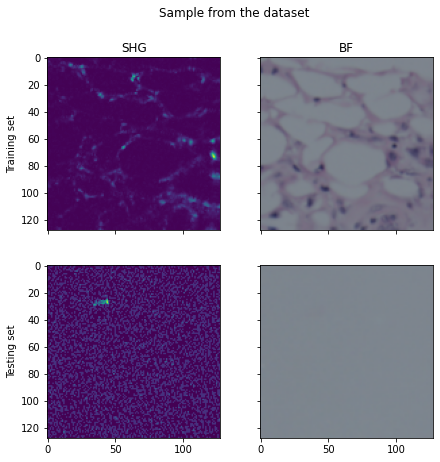

In [7]:
#imgaug.seed(0)
idx = 0 # Img to display
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)
fig.suptitle("Sample from the dataset")
ax[0, 0].set_title(modA_name)
ax[0, 0].set_ylabel("Training set")
sample = dset[idx]
ax[0, 0].imshow(mode2img(sample, modA))
ax[0, 1].set_title(modB_name)
ax[0, 1].imshow(mode2img(sample, modB))
ax[1, 0].set_ylabel("Testing set")
sample = dset_test[idx]
ax[1, 0].imshow(mode2img(sample, modA))
ax[1, 1].imshow(mode2img(sample, modB))

plt.show()

## Training

In [8]:
from models.tiramisu import DenseUNet

class ModNet(DenseUNet):
    def __init__(self, **args):
        super(ModNet, self).__init__(**args, include_top=False)
        out_channels = self.get_channels_count()[-1]
        self.final_conv = torch.nn.Conv2d(out_channels, latent_channels, 1, bias=False)

    def forward(self, x):
        # Penultimate layer
        L_hat = super(ModNet, self).forward(x)
        # Final convolution
        return self.final_conv(L_hat)

torch.manual_seed(0)
modelA = ModNet(in_channels=modA_len, nb_classes=latent_channels, **tiramisu_args).to(device1)
modelB = ModNet(in_channels=modB_len, nb_classes=latent_channels, **tiramisu_args).to(device2)

optimizerA = optimiser(modelA.parameters(), **opt_args)
optimizerB = optimiser(modelB.parameters(), **opt_args)

print("*** MODEL A ***")
modelA.summary()

*** MODEL A ***
Model ModNet has 307 layers.
-> Total number of parameters: 1053596
-> Trainable parameters:       1053596
-> Non-trainable parameters:   0
Uncompressed size of the weights: 4.2MB


Train: 3.702 (min: 1.101, max: 4.175)


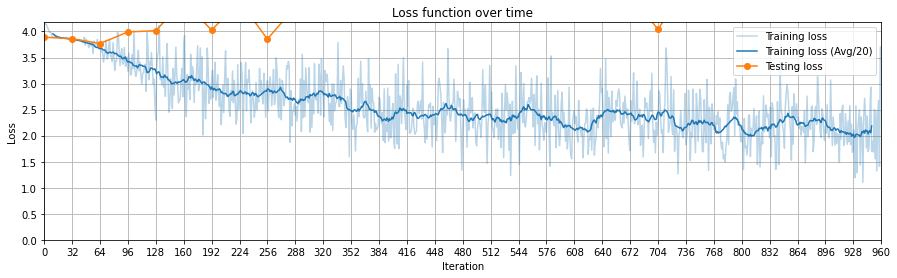

In [17]:
modelA = modelA.to(device1)
modelB = modelB.to(device2)
torch.manual_seed(0)

def plot_losses(data, awidth=20):
    """Plots the losses from a dictionary containing the keys ["train", "test"]
    """
    def moving_average(x, steps=20):
        cs = np.cumsum(x)
        return (cs[steps:] - cs[:-steps]) / steps

    clear_output(wait=True)
    print(
        f'Train: {data["train"][-1]:.3f} '
        f'(min: {np.min(data["train"]):.3f}, max: {np.max(data["train"]):.3f})'
    )
    plt.figure(figsize=(15, 4))
    plt.plot(data["train"], label="Training loss", alpha=0.3)
    if len(data["train"]) > awidth:  
        plt.gca().set_prop_cycle(None)
        t = np.arange(awidth//2, len(data["train"])-awidth//2)
        plt.plot(t, moving_average(data["train"], awidth), label=f"Training loss (Avg/{awidth})")
    t = np.arange(0, steps+1, steps_per_epoch)[:len(data["test"])]
    plt.plot(t, data["test"], "o-", label="Testing loss")
    plt.title("Loss function over time")
    plt.grid(True)
    plt.xlim(0, steps)
    plt.xticks(np.arange(0, steps+1, steps_per_epoch))
    plt.xlabel("Iteration")
    plt.ylim(0, data["train"][0])
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def compute_pairwise_loss(Ls, similarity_fn, tau=1.0, device=None):
    """Computation of the final loss.
    
    Args:
        Ls (list): the latent spaces.
        similarity_fn (func): the similarity function between two datapoints x and y.
        tau (float): the temperature to apply to the similarities.
        device (str): the torch device to store the data and perform the computations.
    
    Returns (list of float):
        softmaxes: the loss for each positive sample (length=2N, with N=batch size).
        similarities: the similarity matrix with all pairwise similarities (2N, 2N)

    Note:
        This implementation works in the case where only 2 modalities are of
        interest (M=2). Please refer to the paper for the full algorithm.
    """
    # Computation of the similarity matrix
    # The matrix contains the pairwise similarities between each sample of the full batch
    # and each modalities.
    points = torch.cat(Ls)
    N = batch_size
    similarities = torch.zeros(2*N, 2*N).to(device)
    for i in range(2*N):
        for j in range(i+1):
            s = similarity_fn(points[i], points[j])/tau
            similarities[i, j] = s
            similarities[j, i] = s

    # Computation of the loss, one row after the other.
    irange = np.arange(2*N)
    softmaxes = torch.empty(2*N).to(device)
    for i in range(2*N):
        j = (i + N) % (2 * N)
        pos = similarities[i, j]
        # The negative examples are all the remaining points
        # excluding self-similarity
        neg = similarities[i][irange != i]
        softmaxes[i] = -pos + torch.logsumexp(neg, dim=0)
    return softmaxes, similarities

losses = {"train": [], "test": []}

def test():
    """Runs the model on the test data."""
    modelA.eval()
    modelB.eval()
    test_loss = []
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            dataA = data.permute(0, 3, 1, 2)[:, modA].to(device1).float()
            dataB = data.permute(0, 3, 1, 2)[:, modB].to(device2).float()
            L1 = modelA(dataA)
            L2 = modelB(dataB)

            softmaxes, similarities = compute_pairwise_loss(
                [L1, L2],
                similarity_fn=sim_func,
                tau=tau,
                device=device1
            )
            loss_test = softmaxes.mean()

            if act_l1 > 0.:
                loss_test += act_l1 * activation_decay([L1, L2], p=1, device=device1)
            if act_l2 > 0.:
                loss_test += act_l2 * activation_decay([L1, L2], p=2, device=device1)
            test_loss.append(loss_test.item())
    losses["test"].append(np.mean(test_loss))
    return loss_test, similarities

test() # First round of testing
for epoch in range(epochs):
    modelA.train()
    modelB.train()
    for batch_idx, data in enumerate(train_loader):
        # Preparing the batch
        dataA = data.permute(0, 3, 1, 2)[:, modA].to(device1).float()
        dataB = data.permute(0, 3, 1, 2)[:, modB].to(device2).float()
        # Reseting the optimizer (gradients set to zero)
        optimizerA.zero_grad()
        optimizerB.zero_grad()

        if equivariance:
            # Applies random 90 degrees rotations to the data (group p4)
            # This step enforces the formula of equivariance: d(f(T(x)), T^{-1}(f(x)))
            # With f(x) the neural network, T(x) a transformation, T^{-1}(x) the inverse transformation
            random_rotA = np.random.randint(4, size=batch_size)
            random_rotB = np.random.randint(4, size=batch_size)
            dataA_p4 = batch_rotate_p4(dataA, random_rotA, device1)
            dataB_p4 = batch_rotate_p4(dataB, random_rotB, device2)

            # Compute the forward pass
            L1 = modelA(dataA_p4)
            L2 = modelB(dataB_p4)

            # Applies the inverse of the 90 degree rotation to recover the right positions
            L1_ungrouped = batch_rotate_p4(L1, -random_rotA, device1)
            L2_ungrouped = batch_rotate_p4(L2, -random_rotB, device2)
        else:
            L1_ungrouped = modelA(dataA)
            L2_ungrouped = modelB(dataB)

        # Computes the loss
        loss = compute_pairwise_loss(
            [L1_ungrouped, L2_ungrouped],
            similarity_fn=sim_func,
            tau=tau,
            device=device1
        )[0].mean()

        # Activation regularization
        if act_l1 > 0.:
            loss += act_l1 * activation_decay([L1, L2], p=1., device=device1)
        if act_l2 > 0.:
            loss += act_l2 * activation_decay([L1, L2], p=2., device=device1)

        # Computing the gradients
        loss.backward()

        # Clipping the the gradients if they are too big
        torch.nn.utils.clip_grad_norm_(modelA.parameters(), grad_norm)
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), grad_norm)
        # Performing the gradient descent
        optimizerA.step()
        optimizerB.step()

        losses["train"].append(loss.item())
        plot_losses(losses)
    # Testing after each epoch
    _, similarities = test()
    plot_losses(losses)

modelA.eval();
modelB.eval();

In [13]:
date = datetime.now().strftime("%Y%d%m_%H%M%S")
if not os.path.exists(export_folder):
    os.makedirs(export_folder)

model_path = os.path.join(export_folder, f"model_{date}.pt")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    torch.save({
        "modelA": modelA,
        "modelB": modelB,
    }, model_path)
print(f"model saved as: {model_path}")
HTML(f'<a href="{model_path}" title="{model_path}" download target="_blank" style="text-decoration:none">🤖 Download model 🤖</a>')

model saved as: results/model_20202204_092923.pt


## Sanity check of the training

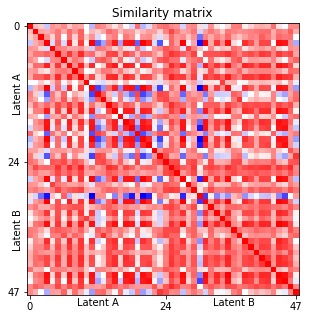

In [19]:
sim_nodiag = similarities[~torch.eye(2*batch_size, dtype=torch.bool)]
vmin, vmax = sim_nodiag.min(), sim_nodiag.max()

plt.figure(figsize=(5, 5))
plt.title("Similarity matrix")
plt.imshow(similarities.cpu().detach(), vmin=vmin, vmax=vmax, cmap="bwr")

N = batch_size
plt.xticks([0, N, 2*N-1], [0, N, 2*N-1])
plt.yticks([0, N, 2*N-1], [0, N, 2*N-1])
ax = plt.gca()
ax.annotate("Latent A", xy=(0, 0), xytext=(N/2, 2*N+1), xycoords="data", textcoords="data",
            horizontalalignment="center", verticalalignment="center")
ax.annotate("Latent B", xy=(0, 0), xytext=(N+N/2, 2*N+1), xycoords="data", textcoords="data",
            horizontalalignment="center", verticalalignment="center")
ax.annotate("Latent A", xy=(0, 0), xytext=(-2, N/2), xycoords="data", textcoords="data",
            horizontalalignment="center", verticalalignment="center", rotation=90)
ax.annotate("Latent B", xy=(0, 0), xytext=(-2, N+N/2), xycoords="data", textcoords="data",
            horizontalalignment="center", verticalalignment="center", rotation=90)
plt.show()

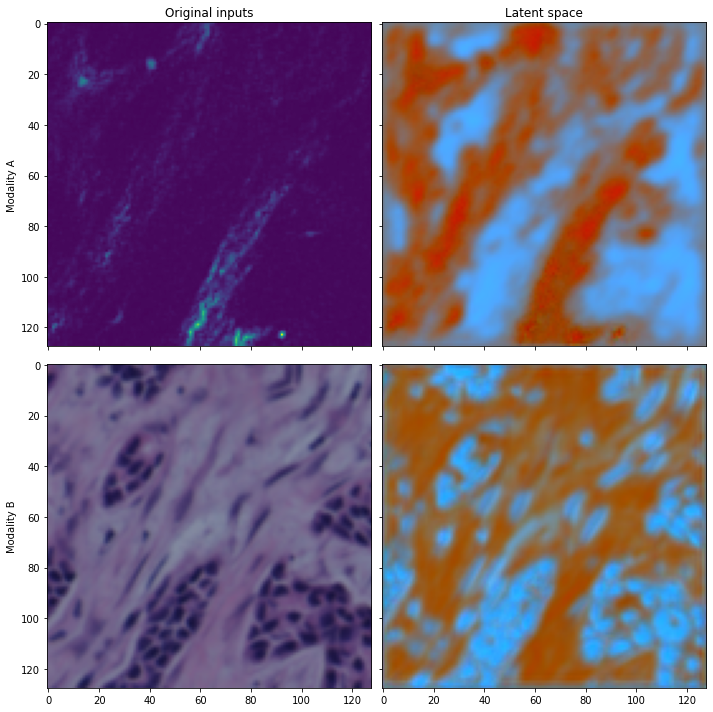

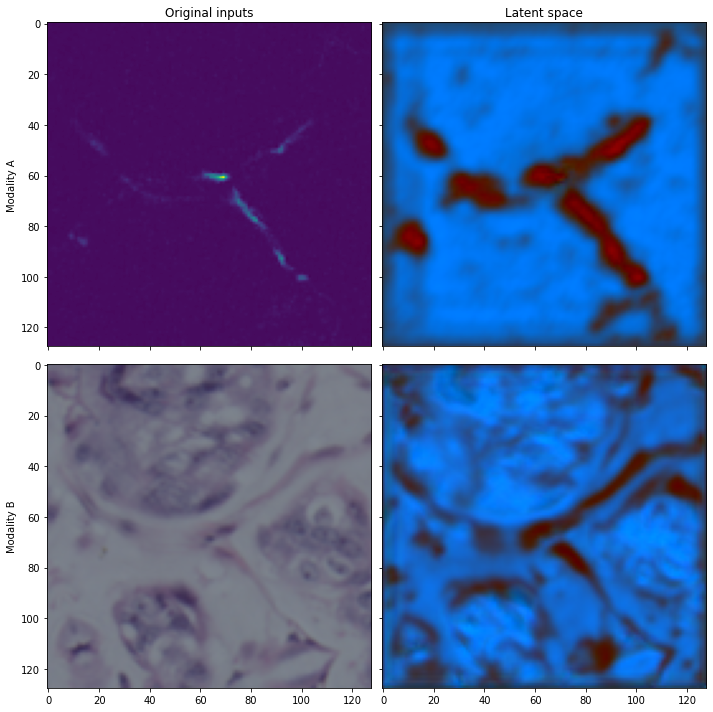

In [20]:
L1 = modelA.to("cpu")(dataA.to("cpu"))
L2 = modelB.to("cpu")(dataB.to("cpu"))

# Example id (can range from 0 to batch_size)
for b in range(2):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    ax[0, 0].set_title("Original inputs")

    # 1st column
    ax[0, 0].set_ylabel("Modality A")
    
    ax[0, 0].imshow(tensor2np(dataA[b]))
    ax[1, 0].set_ylabel("Modality B")
    ax[1, 0].imshow(tensor2np(dataB[b]))

    # 2nd column
    ax[0, 1].set_title("Latent space")
    minint, maxint = min(L1[b].min(), L2[b].min()), max(L1[b].max(), L2[b].max())
    L1n, L2n = normalize_common(L1[b], L2[b])
    ax[0, 1].imshow(L1n)
    ax[1, 1].imshow(L2n)

    plt.tight_layout()
    plt.savefig(os.path.join(export_folder, f"latentspace{b:0>2d}.png"))

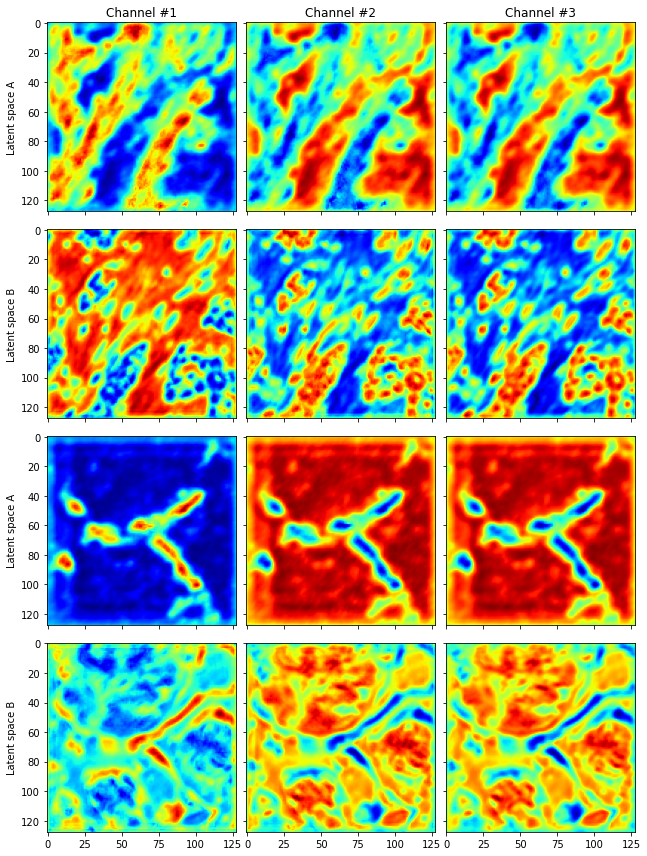

In [21]:
N = 2 # must be between 1 and batch_size

cmap = "jet"
fig, ax = plt.subplots(2*N, latent_channels, sharex=True, sharey=True, figsize=(latent_channels*3, 2*N*3))
for i in range(N):
    for j in range(latent_channels):
        if i == 0:
            ax[i, j].set_title(f"Channel #{j+1}")
        if j == 0:
            ax[i*2+0, j].set_ylabel("Latent space A")
            ax[i*2+1, j].set_ylabel("Latent space B")
        ax[i*2+0, j].imshow(tensor2np(L1[i, j]), cmap=cmap)
        ax[i*2+1, j].imshow(tensor2np(L2[i, j]), cmap=cmap)
plt.tight_layout()
plt.show()

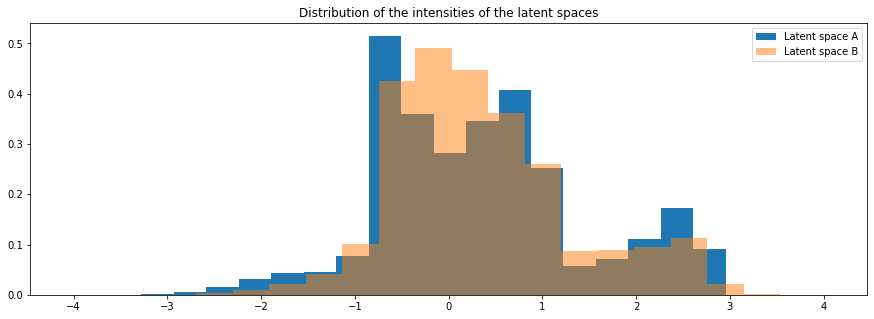

In [22]:
plt.figure(figsize=(15, 5))
plt.title("Distribution of the intensities of the latent spaces")
_, bins1, _ = plt.hist(tensor2np(L1).ravel(), density=True, bins=20, label="Latent space A")
_, bins2, _ = plt.hist(tensor2np(L2).ravel(), density=True, bins=20, alpha=0.5, label="Latent space B")
posmax = max(abs(bins1.min()), abs(bins2.min()), bins1.max(), bins2.max())
plt.xlim(-1.05*posmax, 1.05*posmax)
plt.legend()
plt.show()

## Checking the registration

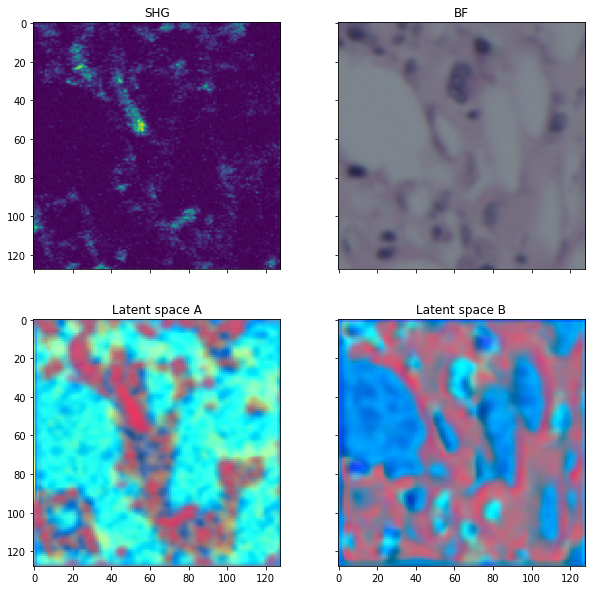

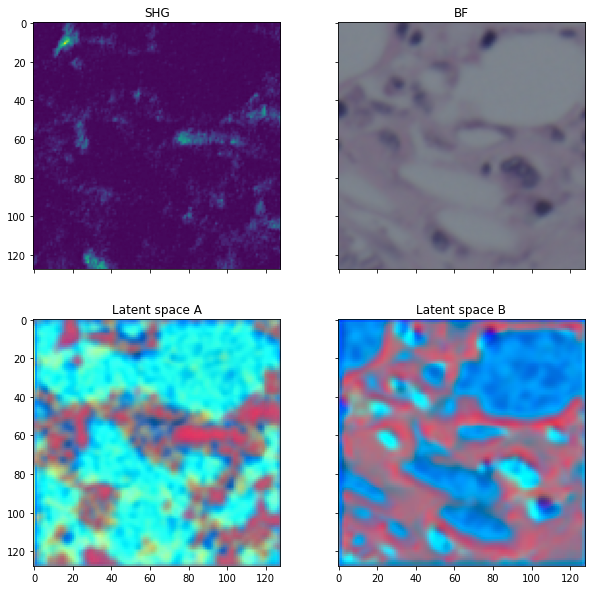

In [28]:
modelA.to(device)
modelB.to(device)
# Element of the batch to display
b = 0

# Position of the point
px, py = -.3, -.3
# Random angle to test
true_angle = 117 # "Randomly" chosen
# Computing the unrotated patch latent spaces
aug  = iaa.Sequential([
    iaa.CropToFixedSize(128, 128, position=(.5+px, .5+py))
])
unrotated = aug.augment_image(dset.get(b, augment=False))
input_image = torch.Tensor(unrotated[np.newaxis].transpose(0, 3, 1, 2)).to(device)
L1u = modelA(input_image[:,modA])
L2u = modelB(input_image[:,modB])
L1un, L2un = normalize_common(L1u[b], L2u[b])

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].set_title(modA_name)
ax[0, 0].imshow(mode2img(unrotated, modA))
ax[0, 1].set_title(modB_name)
ax[0, 1].imshow(mode2img(unrotated, modB))
ax[1, 0].set_title("Latent space A")
ax[1, 0].imshow(L1un, interpolation="None")
ax[1, 1].set_title("Latent space B")
ax[1, 1].imshow(L2un, interpolation="None")
plt.show()

# Computing the rotated patch latent spaces
theta = true_angle / 180 * np.pi
nx = px*np.cos(theta)-py*np.sin(theta)
ny = px*np.sin(theta)+py*np.cos(theta)
aug  = iaa.Sequential([
    iaa.Affine(rotate=true_angle, order=3),
    iaa.CropToFixedSize(128, 128, position=(.5+nx, .5+ny)),
])
rotated = aug.augment_image(dset.get(b, augment=False))
input_image = torch.Tensor(rotated[np.newaxis].transpose(0, 3, 1, 2)).to(device)
L1r = modelA(input_image[:,modA])
L2r = modelB(input_image[:,modB])
L1rn, L2rn = normalize_common(L1r[b], L2r[b])

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].set_title(modA_name)
ax[0, 0].imshow(mode2img(rotated, modA))
ax[0, 1].set_title(modB_name)
ax[0, 1].imshow(mode2img(rotated, modB))
ax[1, 0].set_title("Latent space A")
ax[1, 0].imshow(L1rn, interpolation="None")
ax[1, 1].set_title("Latent space B")
ax[1, 1].imshow(L2rn, interpolation="None")
plt.show()

In [29]:
img1a = tensor2np(L1u[0])
img2a = tensor2np(L2r[0])
img1b = tensor2np(L2u[0])
img2b = tensor2np(L1r[0])

scoresA = []
NsA = []
scoresB = []
NsB = []
t = np.arange(0, 360.5, .5)
for angle in tqdm(t):
    imgrot = sktr.rotate(img2a, angle, order=3)
    mask = imgrot != 0.
    NsA.append(np.sum(mask))
    scoresA.append(np.sum(img1a * mask * imgrot)/NsA[-1])

    imgrot = sktr.rotate(img2b, angle, order=3)
    mask = imgrot != 0.
    NsB.append(np.sum(mask))
    scoresB.append(np.sum(img1b * mask * imgrot)/NsB[-1])
scoresA = np.sqrt(np.maximum(scoresA, 0))
scoresB = np.sqrt(np.maximum(scoresB, 0))

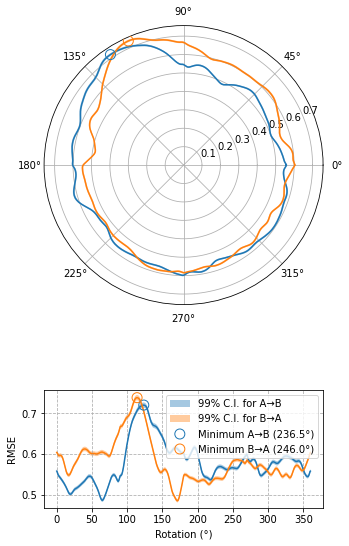

Best A angle: 123.5
Best B angle: 114.0
True angle: 117


In [30]:
cilA, cihA = [], []
cilB, cihB = [], []
for i in range(len(t)):
    Calpha = st.chi2.ppf([0.005, 0.995], NsA[i])
    cilA.append(np.sqrt(NsA[i] / Calpha[0]) * scoresA[i])
    cihA.append(np.sqrt(NsA[i] / Calpha[1]) * scoresA[i])
    Calpha = st.chi2.ppf([0.005, 0.995], NsB[i])
    cilB.append(np.sqrt(NsB[i] / Calpha[0]) * scoresB[i])
    cihB.append(np.sqrt(NsB[i] / Calpha[1]) * scoresB[i])

tr = t*np.pi/180 # linspace in radians

grid = plt.GridSpec(4, 1)
plt.figure(figsize=(5, 10))
ax1 = plt.subplot(grid[:3], projection='polar')
ax1.plot(tr, scoresA)
ax1.fill_between(tr, cilA, cihA, alpha=0.4, label="99% C.I. for A→B")
ax1.plot(tr, scoresB)
ax1.fill_between(tr, cilB, cihB, alpha=0.4, label="99% C.I. for B→A")

xA = np.argmax(scoresA)
ax1.scatter(tr[xA], scoresA[xA], edgecolors="tab:blue", marker="o", facecolors="none", s=100, zorder=3, label=f"Minimum A→B ({360-t[xA]:.1f}°)")

xB = np.argmax(scoresB)
ax1.scatter(tr[xB], scoresB[xB], edgecolors="tab:orange", marker="o", facecolors="none", s=100, zorder=3, label=f"Minimum B→A ({360-t[xB]:.1f}°)")

ax2 = plt.subplot(grid[3:])
ax2.plot(t, scoresA)
ax2.fill_between(t, cilA, cihA, alpha=0.4, label="99% C.I. for A→B")
ax2.plot(t, scoresB)
ax2.fill_between(t, cilB, cihB, alpha=0.4, label="99% C.I. for B→A")
ax2.scatter(t[xA], scoresA[xA], edgecolors="tab:blue", marker="o", facecolors="none", s=100, zorder=3, label=f"Minimum A→B ({360-t[xA]:.1f}°)")
ax2.scatter(t[xB], scoresB[xB], edgecolors="tab:orange", marker="o", facecolors="none", s=100, zorder=3, label=f"Minimum B→A ({360-t[xB]:.1f}°)")
ax2.set_xlabel("Rotation (°)")
ax2.set_ylabel("RMSE")
ax2.grid(linestyle="--")
plt.legend()

plt.show()

print(f"Best A angle: {t[xA]}")
print(f"Best B angle: {t[xB]}")
print(f"True angle: {true_angle}")

### Translation

In [32]:
modelA.to(device)
modelB.to(device)
center = torch.tensor(dset.get(0, augment=False)[236:364, 336:464][np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).to(device)
moved = torch.tensor(dset.get(0, augment=False)[172:428, 272:528][np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).to(device)
center_L1 = modelA(center[:, modA])
moved_L2 = modelB(moved[:, modB])
z = tensor2np(F.conv2d(moved_L2, center_L1, padding=64)[0])

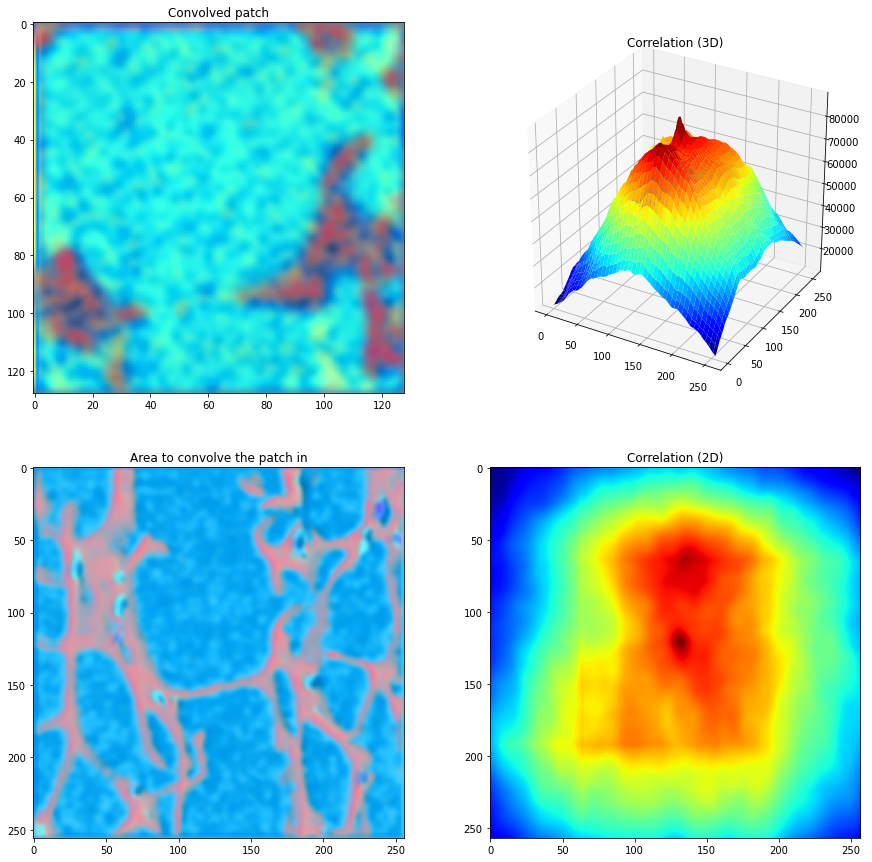

In [33]:
x, y = np.meshgrid(range(z.shape[0]), range(z.shape[1]))
cm = "jet"
# show hight map in 3d
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(221)
ax.set_title("Convolved patch")
ax.imshow(normalize(center_L1[0]), cmap=cm)

ax = fig.add_subplot(222, projection='3d')
ax.set_title("Correlation (3D)")
ax.plot_surface(x, y, z, cmap=cm)

ax = fig.add_subplot(223)
ax.set_title("Area to convolve the patch in")
ax.imshow(normalize(moved_L2[0]), cmap=cm)

# show hight map in 2d
ax = fig.add_subplot(224)
ax.set_title("Correlation (2D)")
ax.imshow(z, cmap=cm)

plt.savefig("correlation.png")

## Looking at the full embedding

In [35]:
idx = 1 # Index of the image to look at in the test set
img = torch.tensor(dset_test.get(idx, augment=False)).permute(2, 0, 1).unsqueeze(0).to("cpu")

# The images are resized
newdim = (np.array(img.shape[2:]) // 128) * 128
img1 = img[:, modA, :newdim[0], :newdim[1]]
print("Image 1:", img1.shape)
img2 = torch.rot90(img[:, modB, :newdim[0], :newdim[1]], k=1, dims=(2, 3))
print("Image 2:", img2.shape)

Image 1: torch.Size([1, 1, 2048, 2048])
Image 2: torch.Size([1, 3, 2048, 2048])


In [36]:
%%time
modelA.to("cpu")
L1 = modelA(img1)

modelB.to("cpu")
L2 = modelB(img2)
L2 = torch.rot90(L2, k=-1, dims=(2, 3))

CPU times: user 2min 46s, sys: 5min 28s, total: 8min 15s
Wall time: 17min 14s


In [55]:
print("Saving unaltered latent spaces...")
date = datetime.now().strftime("%Y%d%m_%H%M%S")
skio.imsave(os.path.join(export_folder, f"L1_{date}.tif"), L1.cpu().detach().numpy())
skio.imsave(os.path.join(export_folder, f"L2_{date}.tif"), L2.cpu().detach().numpy())

print("Creating normalized images...", end="")
def sigmoid(x, tau=1.0):
    """Sigmoid function for ndarrays, safe for big values."""
    return np.exp(-np.logaddexp(
        np.zeros_like(x), - x / tau)
    )

# Temperature of the sigmoid (might require some tuning)
temperature = 1.0

if isinstance(L1[0], torch.Tensor):
    L1_hat = tensor2np(L1[0]).astype(np.float32)
L1_hat = sigmoid(L1_hat, temperature)

if isinstance(L2[0], torch.Tensor):
    L2_hat = tensor2np(L2[0]).astype(np.float32)
L2_hat = sigmoid(L2_hat, temperature)

print(" Saving...")
latent_spaces = [
    os.path.join(export_folder, "L1.png"),
    os.path.join(export_folder, "L2.png")
]
skio.imsave(latent_spaces[0], img2uint8(L1_hat))
skio.imsave(latent_spaces[1], img2uint8(L2_hat))
print("Done.")

Saving unaltered latent spaces...
Creating normalized images... Saving...
Done.


In [57]:
latent_spaces = [os.path.join(export_folder, "L1.png"), os.path.join(export_folder, "L2.png")]
img_list_js = ",".join([f'{{type: "image", url: "{path}"}}' for path in latent_spaces])
openseadragon_cdn = "https://cdn.jsdelivr.net/npm/openseadragon@2.4/build/openseadragon"
HTML(f"""<div id="osd" style="width: 800px; height: 600px;"></div><script src="{openseadragon_cdn}/openseadragon.min.js" integrity="BqvbWCNWGAf21sDh6X5DGseJPJ+iNSRIX/j6rxssCsNw1dbPRaX8TiA9gfy3Jd2F" crossorigin="anonymous"></script><script>var viewer = OpenSeadragon({{id: "osd", prefixUrl: "{openseadragon_cdn}/images/", tileSources: [{img_list_js}], sequenceMode: true, preserveViewport: true}});</script>""")